In [1]:
import atmPy
from atmPy.aerosols.physics import hygroscopicity as hyg
from atmPy.data_archives import arm
from atmPy.aerosols.size_distribution import sizedistribution
%matplotlib inline
plt.style.use('hagen_default')

# HygroscopicGrowthFactorDistributions

We need to generate a data set that can be used to initiate a HygroscopicGrowthFactorDistributions instance. Hiere we take Arm data generated by a HTDMA. The Arm data contains gf-distributions for different diameters, so we select one (200.0 nm).

In [2]:
fname = '../atmPy/unit_testing/test_data/sgptdmahygC1.b1.20120601.004227.cdf'
out = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

# in general

Peaks in the gf-distribution are detected and fit by normal distributions (at log-base). Fit parameters are tightly constrained to avoid run-away parameters and unrealistic results, which in turn can result in unexpacted results ... hard coded fit parameters/boundaries might need adjustment.

# Growth modes

Position of detected growthmodes and ratio of particles in it as a function of time. Here plotted on top of the gf-distribution time series.

(<matplotlib.figure.Figure at 0x116875a90>,
 None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


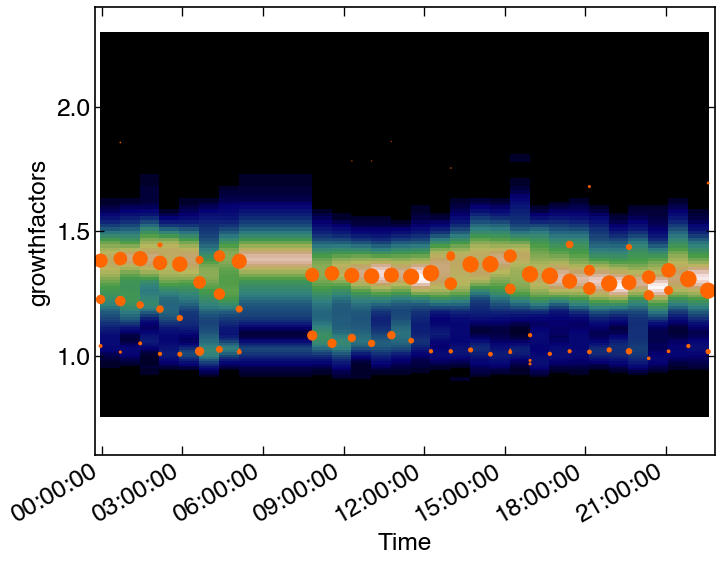

In [11]:
out.hyg_distributions_d200nm.plot(growth_modes=True)

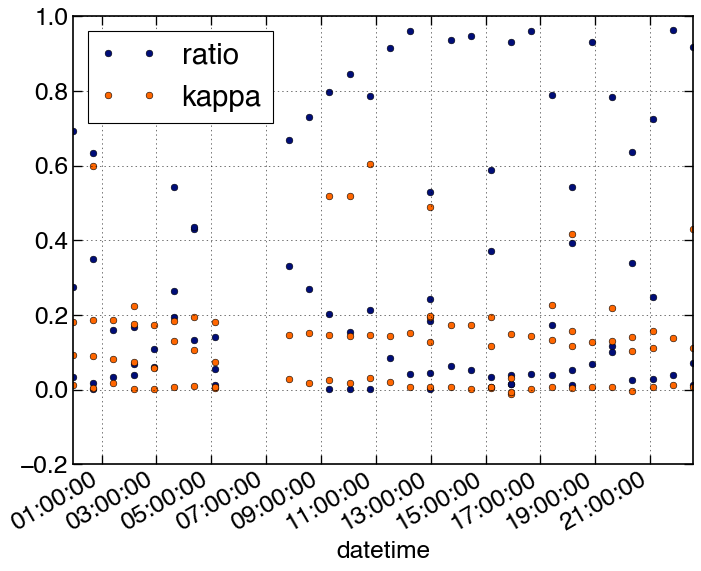

In [12]:
out.hyg_distributions_d200nm.growth_modes_kappa.plot(ls = '', marker = 'o')

# Mixing state

I came up with the following definition, it should be adjusted if there is a better one in the literature
 
Mixing state is given by the pythagoras of the particle ratios of all detected growth modes in a growth distribution. E.g. if there where three modes detected with ratios $r_1$, $r_2$, $r_3$ the mixing state is given by $\sqrt{r_1^2 + r_2^2 + r_3^2}$.

In [ ]:
out.hyg_distributions_d200nm.mixing_state.plot(marker = 'o', ls = '')

# Grown size distribution

this is the sum. for optical properties the individual information is used so the change in the refractive index which is different for each growth mode is considered individually.

In [3]:
fname = '../atmPy/unit_testing/test_data/sgptdmaapssizeC1.c1.20120601.004227.cdf'
tdmaaps = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)
sd = tdmaaps.size_distribution

In [4]:
hgfd = out.hyg_distributions_d200nm
# gmk = out.hyg_distributions_d200nm.growth_modes_kappa

(<matplotlib.figure.Figure at 0x114ea17f0>,
 <matplotlib.colorbar.Colorbar at 0x11b6c6710>)

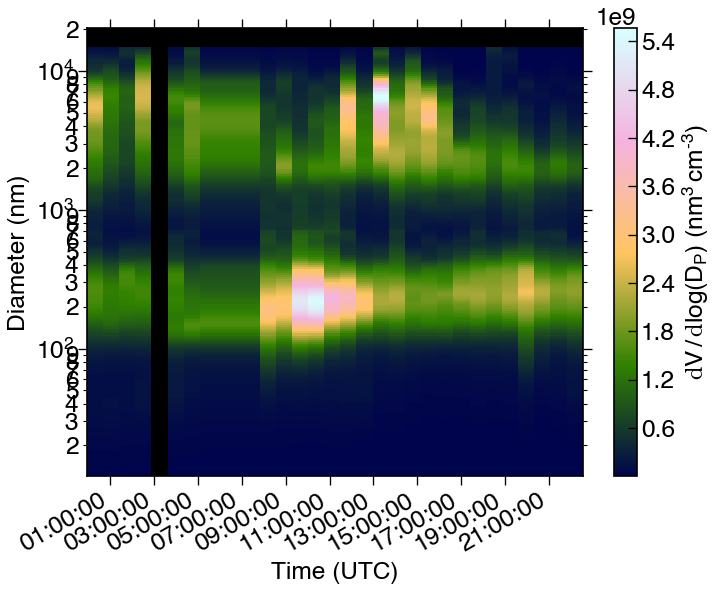

In [18]:
sd.convert2dVdlogDp().plot()

In [5]:
sd.hygroscopicity.parameters.growth_distribution = hgfd
sd.hygroscopicity.parameters.RH = 90

(<matplotlib.figure.Figure at 0x11198c550>,
 <matplotlib.colorbar.Colorbar at 0x111963320>)

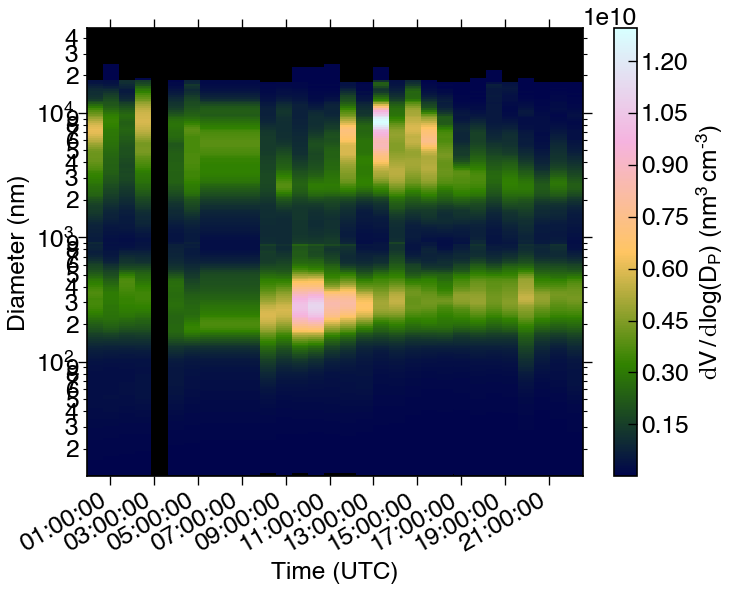

In [9]:
sd.hygroscopicity.grown_size_distribution.sum_of_all_sizeditributions.convert2dVdlogDp().plot()

# Optical properties

## scattering

In [10]:
sd.optical_properties.parameters.wavelength = 550
sd.optical_properties.parameters.refractive_index = 1.5
# sd.hygroscopicity.parameters.RH = 85.

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


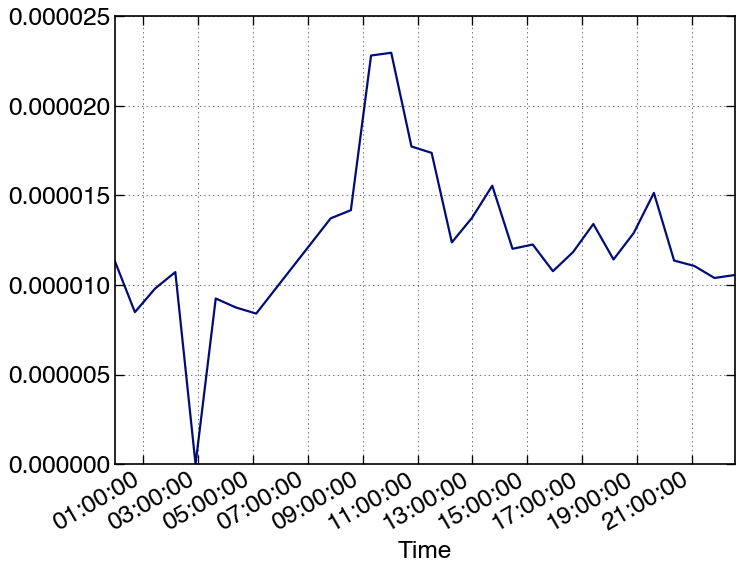

In [11]:
sd.hygroscopicity.grown_size_distribution.optical_properties.scattering_coeff.plot()

## fRH

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


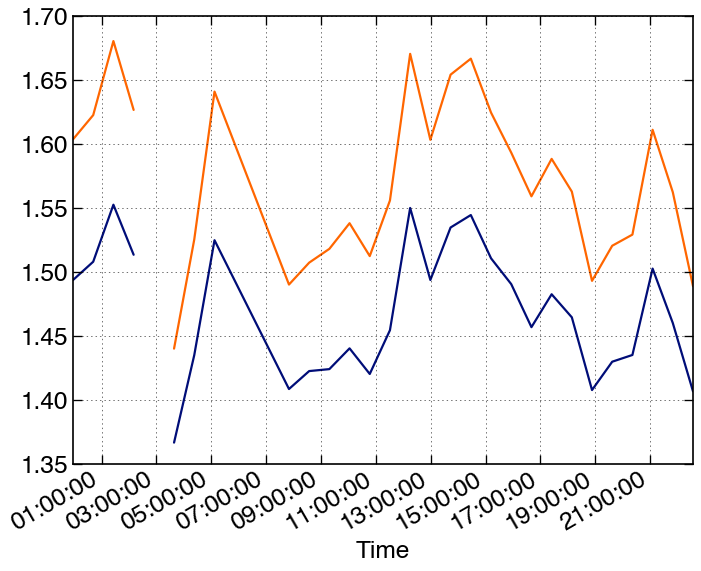

In [12]:
a = sd.hygroscopicity.f_RH_85_40.plot()
sd.hygroscopicity.f_RH_85_0.plot(ax = a)